In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df=df.sort_values(by="QED")
df

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED
1426,Cn1c(-c2cn(CCOCCOCCOCCOCCOCCOCCOCCO)nn2)nc(-c2...,4.94,672.755,2.65520,0.097914
917,OCCOCCOCCOCCOCCOCCOCCOCCn1cc(-c2nc(-c3ccc(F)cc...,4.63,659.712,2.90970,0.098388
821,CCOP(=O)(CCn1cc(-c2ccn3c(-c4ccnc(SC)n4)c(-c4cc...,4.92,568.575,5.23890,0.118764
331,C#CCOCCn1c(SCc2ccc([S+](C)[O-])cc2)nc(-c2ccc(F...,5.30,562.692,4.81100,0.129564
785,COCCNC(=O)c1cc(CCOc2ccc(NC(=O)N=c3cc(C(C)(C)C)...,7.60,620.754,6.09002,0.163197
...,...,...,...,...,...
300,Cc1cccc(Cl)c1NC(=O)c1c[nH]c(=NC(C)C)s1,7.89,309.822,3.59942,0.893935
249,Cc1cccc(Cl)c1NC(=O)c1c[nH]c(=NC2CC2)s1,7.41,307.806,3.35342,0.897331
1405,CCN=c1[nH]cc(C(=O)Nc2c(C)cccc2Cl)s1,6.85,295.795,3.21092,0.897337
1328,Cc1ccc(C(=O)NC2CC2)cc1-c1cnc2c(c1)NC(=O)C2(C)C,7.21,335.407,3.17892,0.904827


In [2]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [3]:
smiles = df['Standardized_SMILES'].values

In [4]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("sorted_fcv_results_RF_training batches.csv", index=False)
    test_df.to_csv("sorted_fcv_results_RF_testing batches.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.7569235260146474, pvalue=5.116346515227196e-28)
PearsonRResult(statistic=0.6750134773963277, pvalue=1.737505059173034e-20)
PearsonRResult(statistic=0.7071823774165511, pvalue=3.9157163069801855e-23)
PearsonRResult(statistic=0.8067554110033603, pvalue=2.9523118864775197e-34)
PearsonRResult(statistic=0.825611987079347, pvalue=4.1166163604249884e-37)
PearsonRResult(statistic=0.8281104889926572, pvalue=1.6234939360135792e-37)
PearsonRResult(statistic=0.7750156061722124, pvalue=4.264934755097467e-30)
PearsonRResult(statistic=0.7135560385363429, pvalue=1.0600808865694252e-23)
PearsonRResult(statistic=0.735050699875385, pvalue=1.3825730002319215e-26)


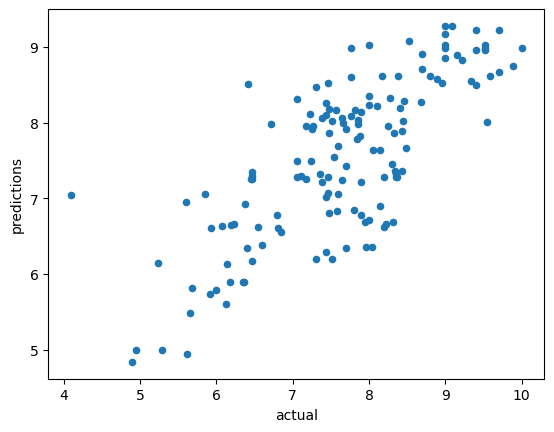

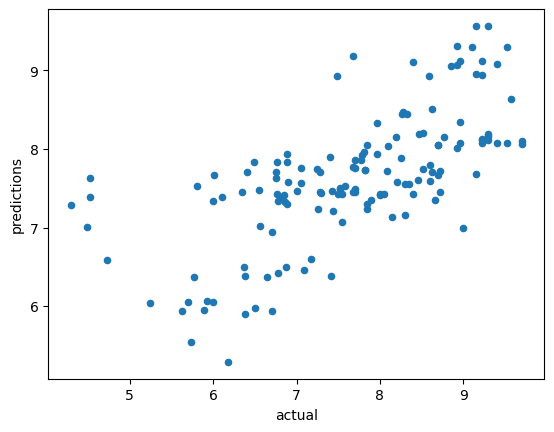

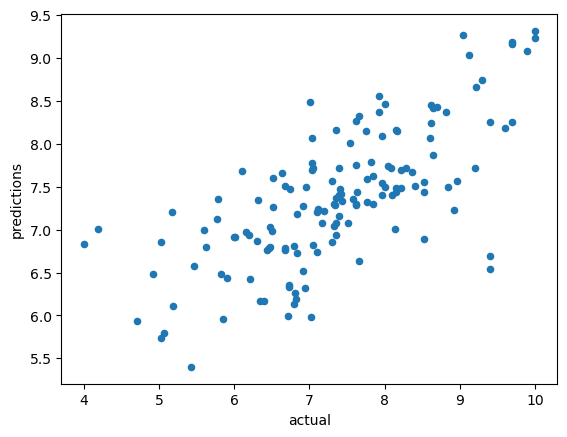

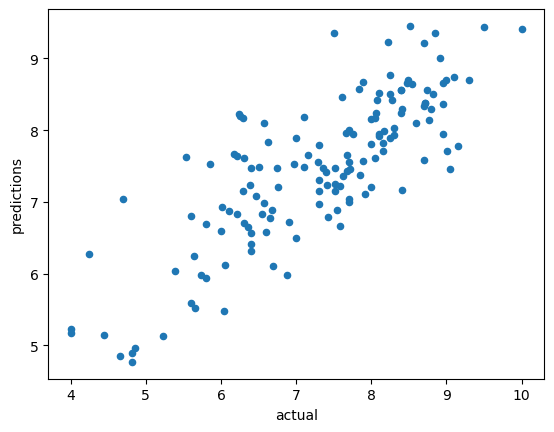

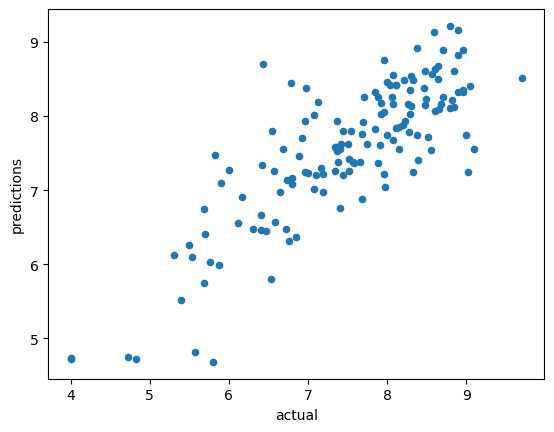

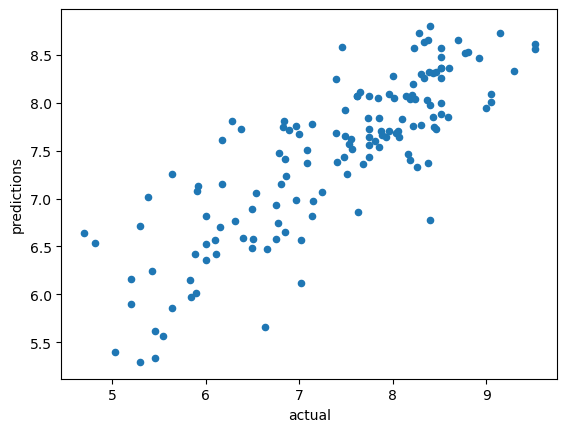

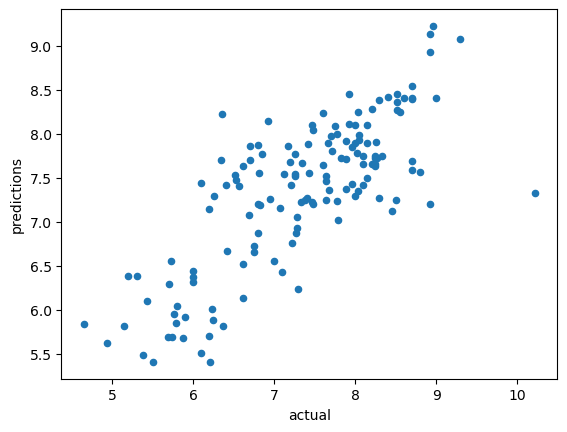

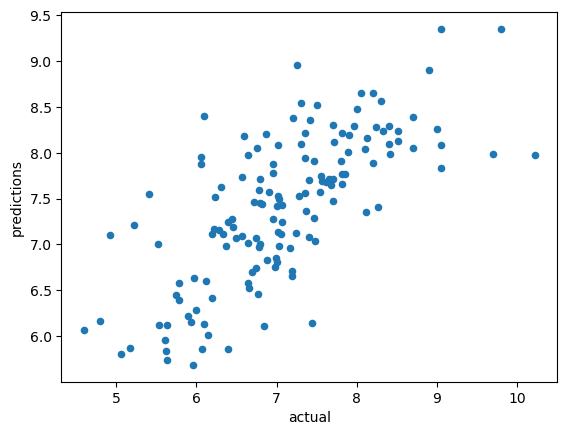

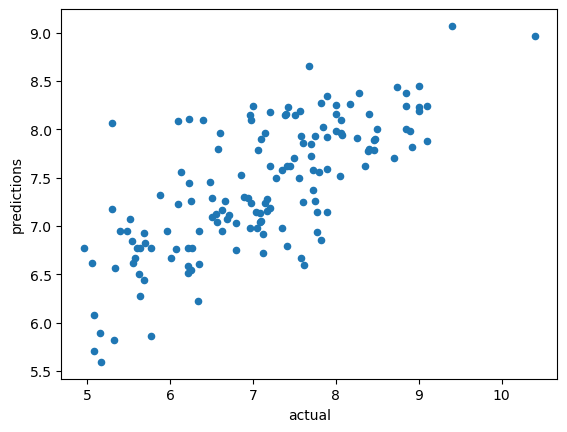

In [6]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [7]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(2, 3)
(0, 3)
(0, 3)
(6, 3)
(4, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [8]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(2, 3)
(0, 3)
(0, 3)
(1, 3)
(2, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [9]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(1, 3)
(5, 3)
(9, 3)
(3, 3)
(0, 3)
(3, 3)
(3, 3)
(5, 3)
(6, 3)


In [10]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(139, 3)
(139, 3)
(135, 3)
(134, 3)
(138, 3)
(139, 3)
(140, 3)
(139, 3)
(143, 3)


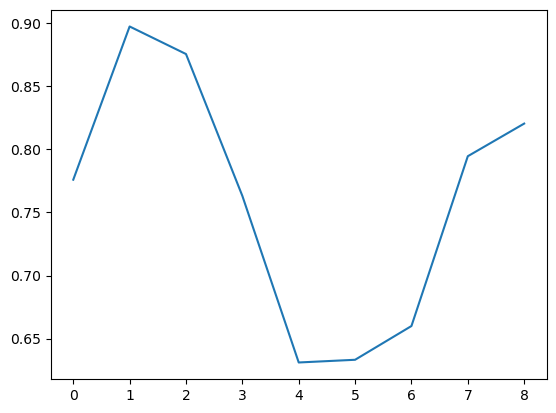

[0.7759451297773279, 0.8973957620196834, 0.8755515204581942, 0.7630936282191871, 0.6310586541677405, 0.6331998322014939, 0.6599574646478698, 0.794557214043702, 0.8204232132619484]


In [11]:
plt.plot(rmse)
plt.show()
print(rmse)

In [12]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

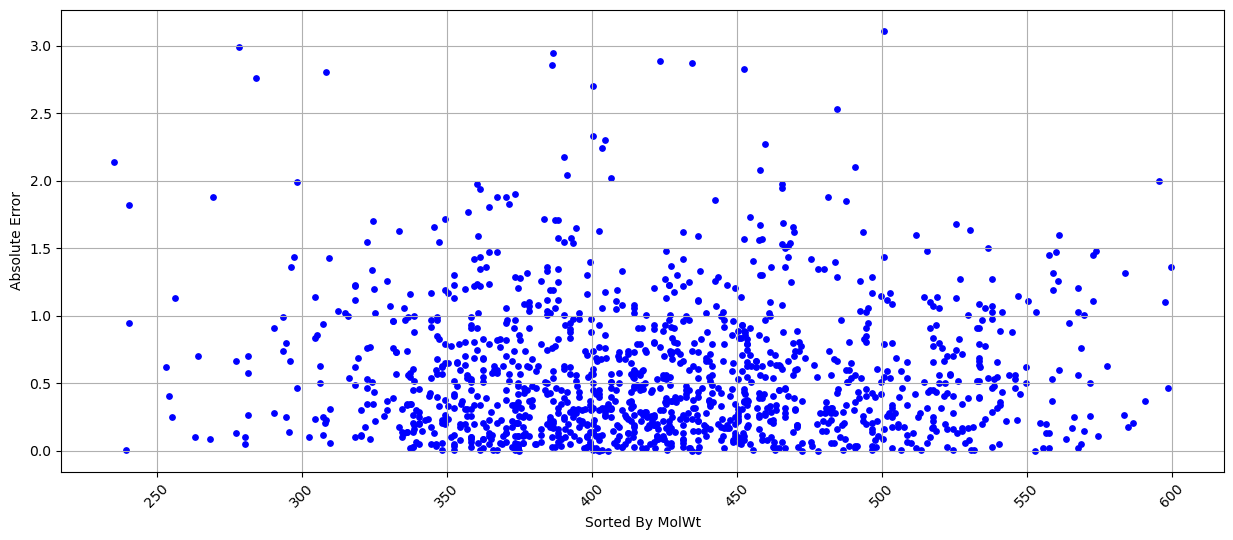

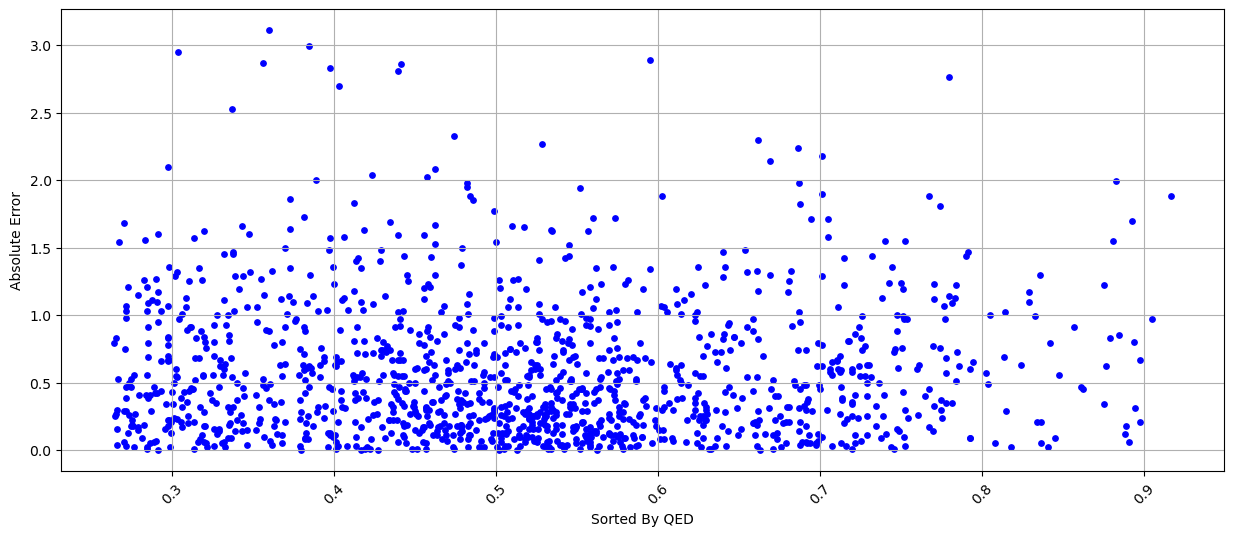

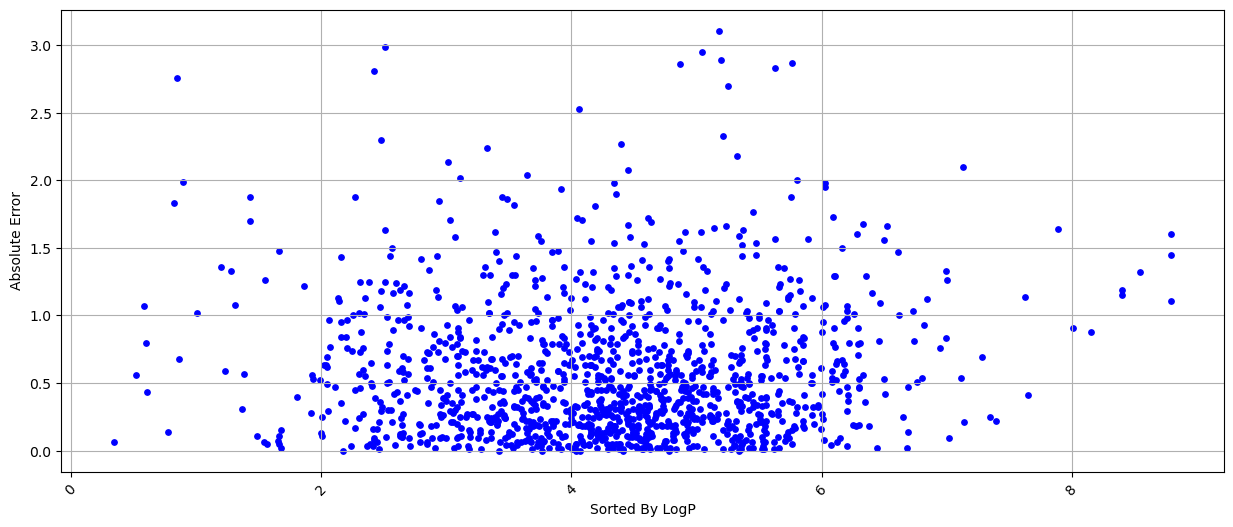

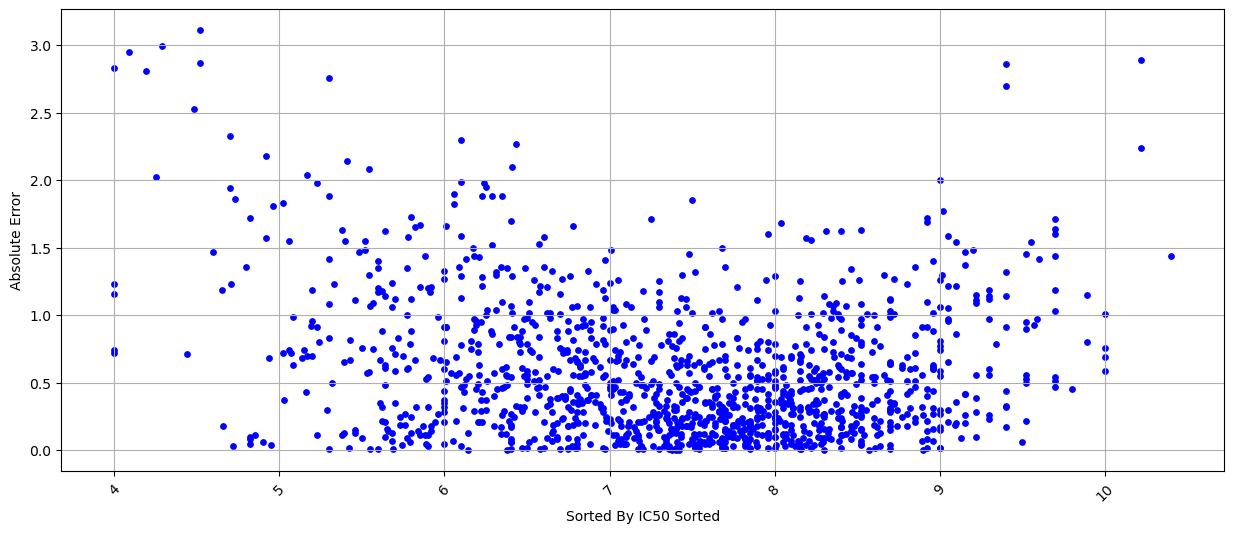

In [13]:
plot_graphs(df, results_df)

In [14]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
1426,Cn1c(-c2cn(CCOCCOCCOCCOCCOCCOCCOCCO)nn2)nc(-c2...,4.94,672.755,2.65520,0.097914,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
917,OCCOCCOCCOCCOCCOCCOCCOCCn1cc(-c2nc(-c3ccc(F)cc...,4.63,659.712,2.90970,0.098388,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
821,CCOP(=O)(CCn1cc(-c2ccn3c(-c4ccnc(SC)n4)c(-c4cc...,4.92,568.575,5.23890,0.118764,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
331,C#CCOCCn1c(SCc2ccc([S+](C)[O-])cc2)nc(-c2ccc(F...,5.30,562.692,4.81100,0.129564,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
785,COCCNC(=O)c1cc(CCOc2ccc(NC(=O)N=c3cc(C(C)(C)C)...,7.60,620.754,6.09002,0.163197,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
300,Cc1cccc(Cl)c1NC(=O)c1c[nH]c(=NC(C)C)s1,7.89,309.822,3.59942,0.893935,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
249,Cc1cccc(Cl)c1NC(=O)c1c[nH]c(=NC2CC2)s1,7.41,307.806,3.35342,0.897331,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1405,CCN=c1[nH]cc(C(=O)Nc2c(C)cccc2Cl)s1,6.85,295.795,3.21092,0.897337,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1328,Cc1ccc(C(=O)NC2CC2)cc1-c1cnc2c(c1)NC(=O)C2(C)C,7.21,335.407,3.17892,0.904827,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        
        X_test = X[(len(X)-fold_size):(len(X))]
        y_test = y[(len(X)-fold_size):(len(X))]
        smiles_test = smiles[(len(X)-fold_size):(len(X))] 
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("sorted_fcv_results_RF_training batches_druglike.csv", index=False)
    test_df.to_csv("sorted_fcv_results_RF_testing batches_druglike.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=-0.06596313089974083, pvalue=0.4321517746778304)
PearsonRResult(statistic=0.14646875936133544, pvalue=0.07981391028658241)
PearsonRResult(statistic=0.2622745113421529, pvalue=0.0014950315276417707)
PearsonRResult(statistic=0.2066276529430887, pvalue=0.012962515172736557)
PearsonRResult(statistic=0.3540506752361455, pvalue=1.3401544338893062e-05)
PearsonRResult(statistic=0.35960571311481826, pvalue=9.570219733622248e-06)
PearsonRResult(statistic=0.42785130128714544, pvalue=8.847137605748929e-08)
PearsonRResult(statistic=0.5998253136286363, pvalue=1.952849242050405e-15)
PearsonRResult(statistic=0.7363227639454026, pvalue=7.334523431671181e-26)


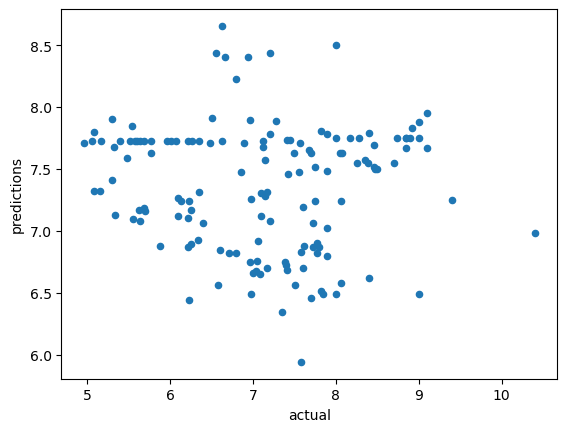

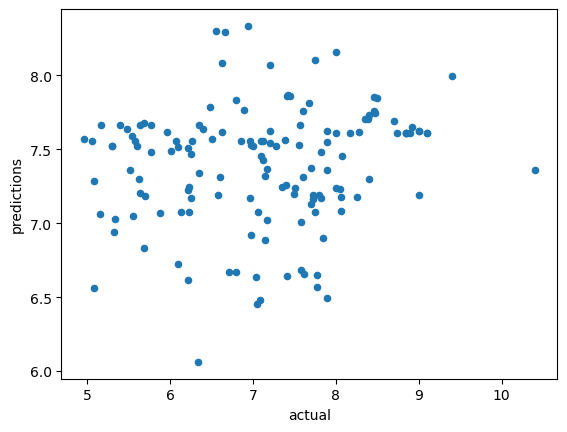

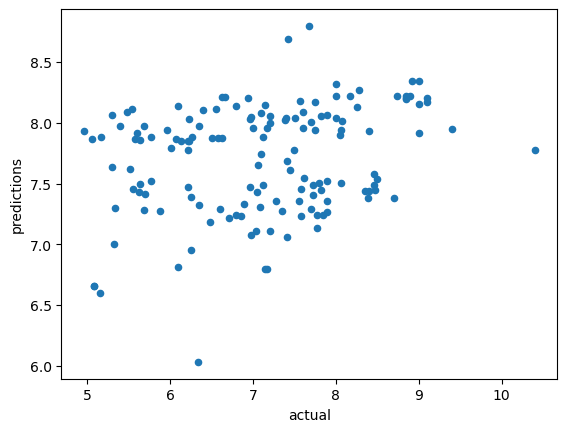

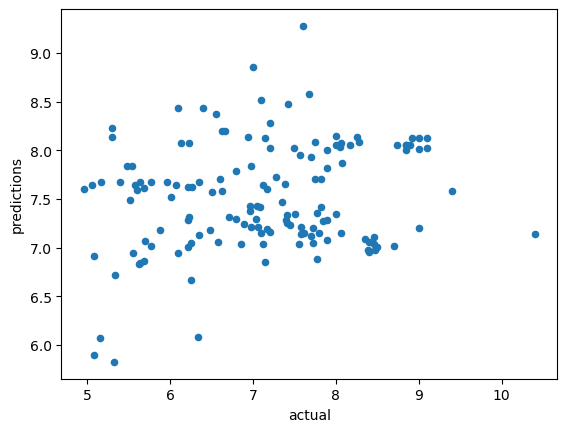

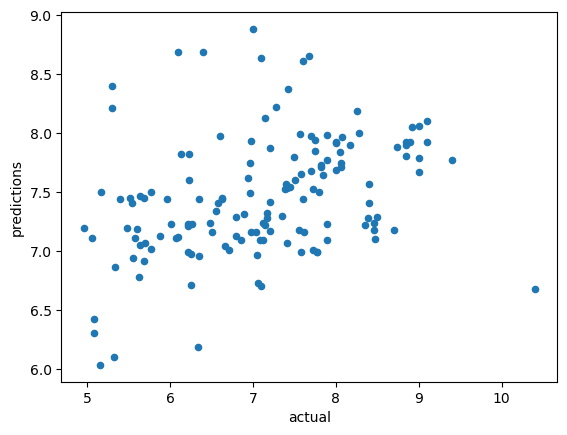

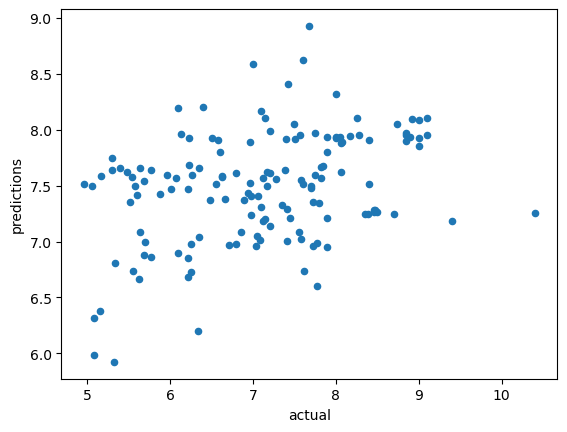

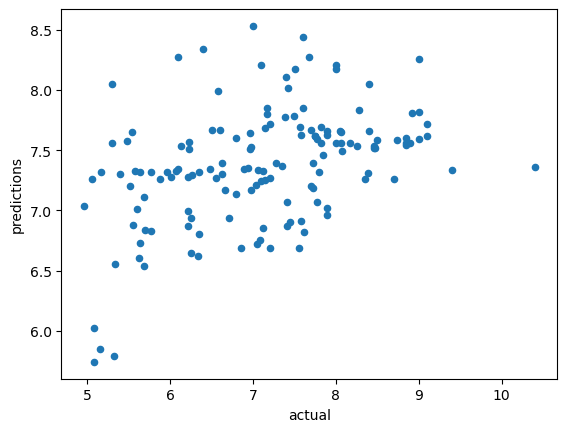

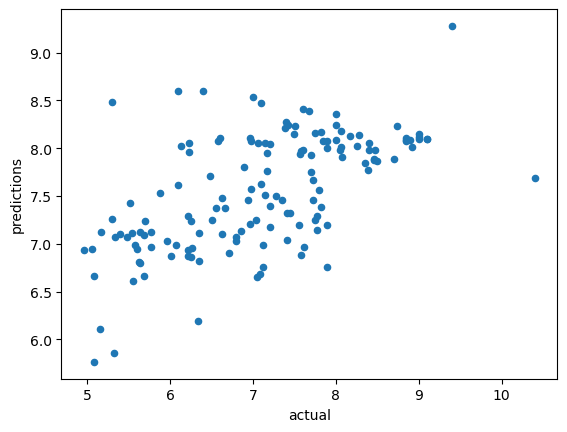

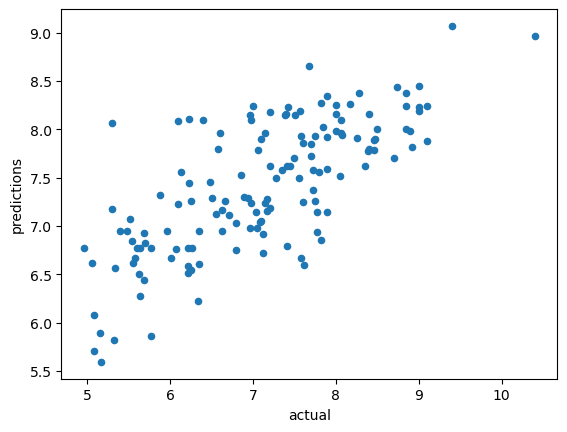

In [16]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [17]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [18]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [19]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(138, 3)
(138, 3)
(138, 3)
(138, 3)
(138, 3)
(138, 3)
(138, 3)
(138, 3)
(138, 3)


In [20]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)
(6, 3)


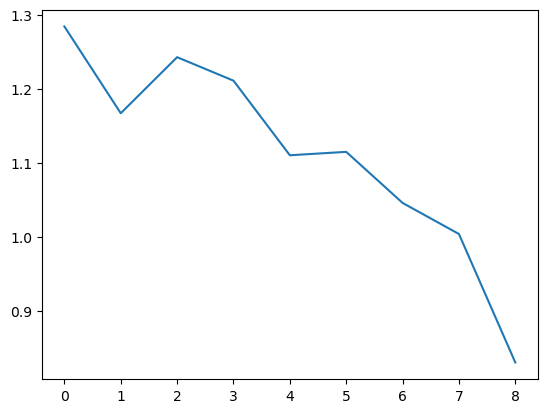

[1.2843554412616691, 1.1672621420677098, 1.2429135233783362, 1.2112355005934468, 1.1105559938857452, 1.1151564446798983, 1.0462801511651751, 1.0043000013829424, 0.8309254297000558]


In [21]:
plt.plot(rmse)
plt.show()
print(rmse)